In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


Hyperparameter initialisation

In [23]:
block_size = 64
batch_size = 128 
max_iters = 30000
learning_rate = 3e-4
eval_iters = 5000

Open text document

In [4]:
with open('wizard_of_oz.txt','r', encoding='utf-8') as f:
    text = f.read()

Get vocabulary

In [5]:
chars = sorted(set(text))
print(chars)
vocab_size = len(chars)
print(vocab_size)

['\n', ' ', '!', '"', '&', "'", '(', ')', '*', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\ufeff']
81


Initialise Encoder and Decoder

In [6]:
string_to_int = {ch:i for i,ch in enumerate(chars)}
int_to_string = {i:ch for i,ch in enumerate(chars)}

encode = lambda s: [string_to_int[c] for c in s]
decode = lambda l: ''.join([int_to_string[i] for i in l])

Gather encoded data from our text document 

In [7]:
data = torch.tensor(encode(text), dtype=torch.long)

Get train and validation splits

In [8]:
n=int(0.8*len(data))
train_data = data[:n]
valid_data = data[n:]

In the get_batch function, we are pushing the data to the GPU to be parallely processed

In [9]:
def get_batch(split):
    data = train_data if split == 'train' else valid_data
    ix = torch.randint(len(data) - block_size,(batch_size,))
    #print(ix)
    x = torch.stack([data[i:i+block_size]for i in ix])
    y = torch.stack([data[i+1:i+block_size+1]for i in ix])
    x,y = x.to(device), y.to(device)
    return x,y

x,y = get_batch('train')
print('inputs')
print(x)
print('targets')
print(y)

inputs
tensor([[79,  9,  1, 37, 71, 11,  1, 26],
        [73,  1, 33,  1, 57, 68, 67,  5],
        [54, 67, 64,  1, 78, 68, 74,  1],
        [58,  1, 46, 54, 65, 65, 58, 78]], device='cuda:0')
targets
tensor([[ 9,  1, 37, 71, 11,  1, 26, 54],
        [ 1, 33,  1, 57, 68, 67,  5, 73],
        [67, 64,  1, 78, 68, 74,  1, 75],
        [ 1, 46, 54, 65, 65, 58, 78,  1]], device='cuda:0')


In [10]:
x = train_data[:block_size]
y = train_data[1:block_size + 1]

for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print('when input is ',context,' target is ',target)

when input is  tensor([80])  target is  tensor(1)
when input is  tensor([80,  1])  target is  tensor(1)
when input is  tensor([80,  1,  1])  target is  tensor(28)
when input is  tensor([80,  1,  1, 28])  target is  tensor(39)
when input is  tensor([80,  1,  1, 28, 39])  target is  tensor(42)
when input is  tensor([80,  1,  1, 28, 39, 42])  target is  tensor(39)
when input is  tensor([80,  1,  1, 28, 39, 42, 39])  target is  tensor(44)
when input is  tensor([80,  1,  1, 28, 39, 42, 39, 44])  target is  tensor(32)


nn.Module inside a sub class, they will be learnable parameters. 
The weight matrix will change through gradient descent.

Now why Gradient Descent, to avoid loss in the model. 
How do we calculate loss, -log(1/80) -> This is an example case where we are finding the probability that we get a character from a 80 word vocabulary. Now the calculated loss is 

In [11]:
import math
print(-math.log(float(1/80)))

4.382026634673881


This loss is huge, not even 2% chance to predict that specific character. 

We have to apply gradient descent so that in that graph of plotted wave, the prediction is adjusted along the curve of the wave to avoid this loss we acquire.

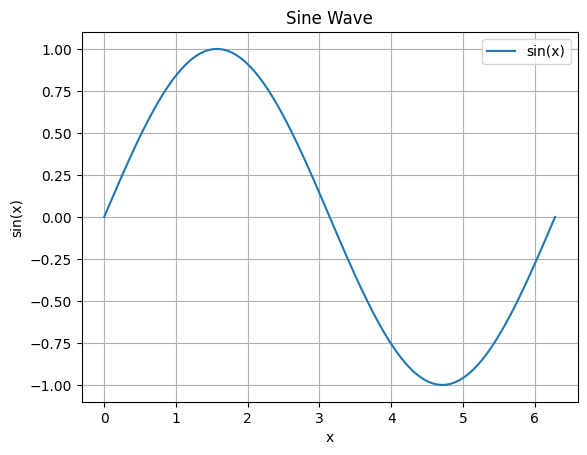

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Generate values from 0 to 2π
x = np.linspace(0, 2 * np.pi, 100)
y = np.sin(x)

# Plot the sine wave
plt.plot(x, y, label="sin(x)")

# Labels and title
plt.xlabel("x")
plt.ylabel("sin(x)")
plt.title("Sine Wave")

# Show legend and grid
plt.legend()
plt.grid()

# Display the plot
plt.show()


***Gradient descent*** is an optimiser for the network. We can check torch optim for all optimisers that can be used from the torch framework.

Now this optimiser must be paired with a learning rate. As we adjust our prediction with the optimiser, we must specify how it adjusts, which is done by the learning rate. Learning rate allows us to commmand the optimiser to take the steps or jumps that it must take to follow the curve of the gradient. 


***Why learning rate?*** To avoid immediate ascending and descending. When we adjust learing rate it will allow the optimiser to know when we descend or ascend based on when we reach the local bottom (base line)  

Its better to have **smaller learing rate** so that we dont take large steps that we drastically change the parameters we are working with.

***AdamW optimiser*** - We use this since the weight matrix in the neural network may be lucky or unlucky to achieve a high or low accuracy inconsistently. We decay the weights with the AdamW to make sure the weights are consistent in the learning process.

***Logits:***


These are the probability distribution of what we want to predict.


Above we are reshaping (.shape and .view) the logits are in the format PyTorch expects it to be.

In [12]:
@torch.no_grad()
def estimate_loss():
    out={}
    #testing
    model.eval() #evaluation  mode (dropout is off here)
    for split in ['train','val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train() #sampling and challenging the network
    return out

We have used a **decorater** so that other classes won't conflict with certain cases. Here we use the model, but we dont want the gradient acting here.


This also reduces computation since it wont use the gradient

In [13]:
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        #nn.Embedding is a look up table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size) #Learnable parameter
        
    #important to forward pass for understanding, debugging and optimisation - best practice
    def forward(self, index, targets=None):
        logits = self.token_embedding_table(index)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss

    def generate(self, index, max_new_tokens):
        #index is (B,T) array of indices in the current context
        for _ in range(max_new_tokens):
            #get predictions
            logits, loss = self.forward(index)
            #focus only on the last time step for Bigram
            logits = logits[:,-1,:] #becomes (B,C)
            #apply softmax to get the probabilities
            probs = F.softmax(logits, dim=-1) #(B,C)
            #sample from distribution
            index_next = torch.multinomial(probs, num_samples=1) #(0,1)
            #append sampled index to the running sequence
            index = torch.cat((index, index_next), dim=1) #(B, T+1)

        return index

model = BigramLanguageModel(vocab_size)
m = model.to(device)

context = torch.zeros((1,1),dtype=torch.long, device = device)
generated_chars = decode(m.generate(context, max_new_tokens=500)[0].tolist())
print(generated_chars)


!d(jK5ol"MH"Gd6Kws.?FG8xrDnmJ1(CMsu82(wFZy]n_&F!d9
feBcZv47jinC6!QCSPLblMlXuOPAovwYd'8D)BTX&XVnD4 gS5ley"Y5MqYyrztPIS*?4x,_qZ(eR"CREgmAF
eguig8EG7P
snB y﻿ X1;uN(ab
:jgU7PAt9gXTf[cwegwFK4Jn"Hse!]JfSeA9"3;FG(eSMOIhKdtbB7j[McV3V:yoRK'ZW*;7﻿5vRTL7LTTrxClbSW﻿ji- MN4aQeDl"e9)O,!*H2u"Ju1qks﻿ aqaax7,cN22CSUdYr7hV?GD:Tz M9iY.?[*FK
6JHDt-pzkThv2YZQ?h!2W?:C&-_EGWnN[cZmFA'YrM
n*J.:Soy1-**?&g[MHMUHB8,iG3O6JZFVG_xns:UTB0.?"1HHUF[﻿GhITPM﻿1qF[SkE-sUmQD3hu"8!"EHszNzmF&p9cAKi:a!:"QX﻿!Q0u,?zgTL,6Ru!﻿yQ'D]wcgpaeFC)


Here we have witnessed an unoptimised output generated from the bigram.


Now we create the optimiser

In [24]:
#PyTorch Optimiser
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):
    if iter % eval_iters == 0:
        losses = estimate_loss()
        print(f"Step: {iter}, train loss:{losses['train']:.3f}, val loss:{losses['val']:.3f}")
    #sample a batch of data
    xb, yb = get_batch('train')

    #evaluate the loss
    logits, loss = model.forward(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
print(loss.item())

Step: 0, train loss:2.418, val loss:2.474
Step: 5000, train loss:2.418, val loss:2.475
Step: 10000, train loss:2.418, val loss:2.475
Step: 15000, train loss:2.418, val loss:2.475
Step: 20000, train loss:2.418, val loss:2.475
Step: 25000, train loss:2.418, val loss:2.475
2.42146897315979


In [15]:
context = torch.zeros((1,1), dtype=torch.long, device=device)
generated_chars = decode(m.generate(context, max_new_tokens=500)[0].tolist())
print(generated_chars)



wheve ane d tousoy uddopre fo oneitothulore ane al!"
ar and tu rrdid s maly-3S riz beyokLF
TE!"
To cegary ainno)C-gharira, ar e; b;"
Fnthed PZ(I airc ha f  awouf 1Sooflenlef we wiz2]G!"OO6:venoomest tocry iofied y:A the
llilde
"

ho bkGhee sllqPIp!HAsun t les ble tchanthe r ZSld vV("anthelN?s g grd
Wow gefint w Wkink[RroussqEAX0UGoreteratlale., hy cZDouthirer ps," GThenigarroweyly thyo d trpedueanp!Bin. t'BurlexV]Rud y werrn as t ir as, a nht spavizmsus the ouseemTH." w?RGNAIacte ry thetherelay


One thing to ***note*** is we use **dropout** for neural network optimisation. If we have noise in the network the dropout just randomly drops out neurons from the network so that there wont be bias as well. It makes sure that the prediction part stays to just predicting based on knowledge and not bias, which also improves training by preventing ***overfitting***.

In [22]:
print(f"GPU Memory Allocated: {torch.cuda.memory_allocated() / 1024**2} MB")
print(f"GPU Memory Reserved: {torch.cuda.memory_reserved() / 1024**2} MB")

GPU Memory Allocated: 0.7666015625 MB
GPU Memory Reserved: 4.0 MB
